In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: /workspace/iscat


In [27]:
hdf5_path = "dataset/brightfield_instance.hdf5"

In [37]:
import json
with h5py.File(hdf5_path, 'r') as f:
    # Load data
    print( len(f['instance_annotations']))
    categories = json.loads(f.attrs['categories'])
categories

879


[{'id': 0, 'name': 'Cy5', 'size_nm': 80},
 {'id': 1, 'name': 'FITC', 'size_nm': 300},
 {'id': 2, 'name': 'TRITC', 'size_nm': 1300}]

In [39]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import json
import random

def generate_distinct_colors(n):
    """Generate n visually distinct colors."""
    colors = []
    for i in range(n):
        hue = i / n
        color = plt.cm.hsv(hue)[:3]  # Get RGB values
        colors.append(color)
    return colors

def visualize_sample(hdf5_path, sample_idx=0, slice_idx=0):
    """
    Visualize a sample from the HDF5 file with its instance segmentations and bounding boxes.
    
    Args:
        hdf5_path (str): Path to the HDF5 file
        sample_idx (int): Index of the sample to visualize
        slice_idx (int): Index of the slice to visualize for 3D images
    """
    with h5py.File(hdf5_path, 'r') as f:
        # Load data
        image = f['images'][sample_idx]
        semantic_masks = f['semantic_masks'][sample_idx]
        
        # Load categories
        categories = json.loads(f.attrs['categories'])
        category_names = [cat['name'] for cat in categories]
        
        # Find and load instance annotations for this image
        instance_data = None
        for i in range(len(f['instance_annotations'])):
            annotation = json.loads(f['instance_annotations'][i])
            if annotation['image_id'] == sample_idx:
                instance_data = annotation
                break

    # Normalize 16-bit image
    image_slice = image[slice_idx].astype(float) / (2**16)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    ax1.imshow(image_slice, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Plot semantic segmentation
    semantic_overlay = np.zeros((*image_slice.shape, 3))
    semantic_colors = [(1,0,0,0.5), (0,1,0,0.5), (0,0,1,0.5)]  # Red, Green, Blue with alpha
    
    for i, mask in enumerate(semantic_masks):
        for c in range(3):
            semantic_overlay[..., c] += mask * semantic_colors[i][c]
    
    ax2.imshow(image_slice, cmap='gray')
    ax2.imshow(semantic_overlay, alpha=0.5)
    ax2.set_title('Semantic Segmentation')
    ax2.axis('off')
    
    # Add legend for semantic segmentation
    semantic_patches = [Patch(color=semantic_colors[i][:3], label=f"{cat['name']} ({cat['size_nm']}nm)")
                       for i, cat in enumerate(categories)]
    ax2.legend(handles=semantic_patches, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Plot instance segmentation and bounding boxes
    ax3.imshow(image_slice, cmap='gray')
    ax3.set_title('Instance Segmentation & Bboxes')
    
    if instance_data and 'instances' in instance_data:
        instances = instance_data['instances']
        instance_colors = generate_distinct_colors(len(instances))
        
        for inst, color in zip(instances, instance_colors):
            # Convert segmentation from list back to numpy array
            mask = np.array(inst['segmentation'], dtype=np.uint8)
            
            # Plot instance mask
            mask_overlay = np.zeros((*image_slice.shape, 4))  # RGBA
            for c in range(3):
                mask_overlay[..., c] = mask * color[c]
            mask_overlay[..., 3] = mask * 0.5  # Alpha channel
            
            ax3.imshow(mask_overlay)
            
            # Plot bounding box
            bbox = inst['bbox']
            rect = Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                linewidth=1,
                edgecolor=color,
                facecolor='none'
            )
            ax3.add_patch(rect)
            
            # Add text with category name
            category = categories[inst['category_id']]['name']
            ax3.text(bbox[0], bbox[1] - 2, category, color=color, 
                    fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

def print_dataset_info(hdf5_path):
    """Print information about the dataset structure and contents."""
    with h5py.File(hdf5_path, 'r') as f:
        print("Dataset Structure:")
        print(f"Number of images: {len(f['images'])}")
        print(f"Image shape: {f['images'].shape}")
        print(f"Semantic masks shape: {f['semantic_masks'].shape}")
        print(f"Number of instance annotations: {len(f['instance_annotations'])}")
        
        # Print category information
        categories = json.loads(f.attrs['categories'])
        print("\nCategories:")
        for cat in categories:
            print(f"- {cat['name']}: {cat['size_nm']}nm (ID: {cat['id']})")
        
        # Print sample instance statistics
        total_instances = 0
        instances_per_category = {cat['id']: 0 for cat in categories}
        
        for i in range(min(len(f['instance_annotations']), 100)):  # Sample first 100 annotations
            annotation = json.loads(f['instance_annotations'][i])
            if 'instances' in annotation:
                total_instances += len(annotation['instances'])
                for inst in annotation['instances']:
                    instances_per_category[inst['category_id']] += 1
        
        print("\nInstance Statistics (from first 100 patches):")
        print(f"Total instances: {total_instances}")
        for cat in categories:
            print(f"- {cat['name']}: {instances_per_category[cat['id']]} instances")


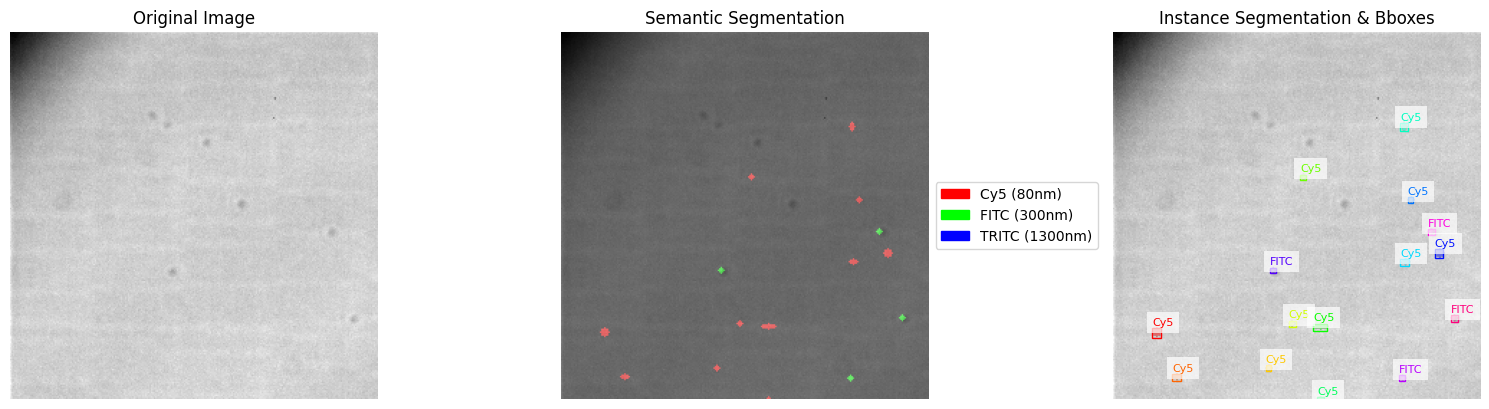

In [40]:
visualize_sample(hdf5_path, sample_idx=0, slice_idx=0)

In [43]:
particle_data_path ='dataset/particles.hdf5'
with h5py.File(particle_data_path , 'r') as f:
    print(f['data'].shape)

(41350, 16, 201)
